In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots
import time

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

from merfish_datasets import merfish_datasets
directories = merfish_datasets
print(merfish_datasets)

{'P14NR_ant': 'merfish_06142023/ant/region0', 'P28NR_ant': 'merfish_06142023/ant/region1', 'P14NR_pos': 'merfish_06142023/pos/region0', 'P28NR_pos': 'merfish_06142023/pos/region1', 'P21NR_ant': 'merfish_20231114/region0', 'P21DR_ant': 'merfish_20231114/region2', 'P28DR_ant': 'merfish_20231114/region1', 'P21NR_pos': 'merfish_20231120/region0', 'P21DR_pos': 'merfish_20231120/region1', 'P28DR_pos': 'merfish_20231120/region2'}


In [3]:
name = 'P28NR_pos'
dirc = directories[name]

full_dirc = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/{dirc}/'
f_main    = f'/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/data/merfish/organized/{name}_ctxglut_240411.h5ad'
f1   = full_dirc + 'detected_transcripts.csv'
# f2   = full_dirc + 'cell_metadata.csv'
fout = full_dirc + 'detected_transcripts_v1l23.csv'

In [4]:
adata = ad.read(f_main)
bound_l, bound_r, bound_d = adata.uns['bound_lrd']
cond = np.all([
    adata.obs['width'] > bound_l, 
    adata.obs['width'] < bound_r, 
    adata.obs['depth'] < bound_d, 
], axis=0)
adatasub = adata[cond]

rotation_angle = adata.uns['rotation']
ref_line = np.array(adata.uns['ref_line'])

adatasub

View of AnnData object with n_obs × n_vars = 3696 × 500
    obs: 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'gncov', 'gnnum', 'fpcov', 'x', 'y', 'depth', 'width', 'inside_v1l23'
    uns: 'bound_lrd', 'ref_line', 'rotation'
    obsm: 'blanks', 'pca'
    layers: 'norm'

In [5]:
# get FOVs
fovs = np.unique(adatasub.obs['fov'])
fovs.shape, fovs

((34,),
 array([2111, 2155, 2156, 2157, 2158, 2159, 2160, 2202, 2203, 2204, 2205,
        2206, 2207, 2208, 2250, 2251, 2252, 2253, 2254, 2255, 2256, 2296,
        2297, 2298, 2299, 2300, 2301, 2302, 2303, 2340, 2341, 2342, 2343,
        2344]))

# get transcripts in V1 L2/3

In [6]:
# go over all tranascripts - select only those that are within these FOVs
chunks = pd.read_csv(f1, chunksize=1000000)
dfsubs = []

ti = time.time()
for i, chunk in enumerate(chunks):
    print(i, time.time()-ti)
    dfsub = chunk[chunk['fov'].isin(fovs)]
    if len(dfsub) > 0:
        print(len(dfsub))
        dfsubs.append(dfsub)

0 2.026806592941284
1 3.605659008026123
2 4.9899091720581055
3 6.43412446975708
4 7.790478467941284
5 9.43444561958313
6 10.93601393699646
7 12.919664144515991
8 14.665390253067017
9 16.206166982650757
10 17.562156200408936
11 18.968299627304077
12 20.35319423675537
13 21.792407274246216
14 23.825977325439453
15 25.804558992385864
16 27.27945327758789
17 28.797492265701294
18 30.16241431236267
19 31.55880570411682
20 33.5551598072052
21 35.28461146354675
22 37.158817291259766
23 39.21499490737915
24 40.69664669036865
25 42.217342376708984
26 44.43218159675598
27 46.368489503860474
28 47.90861392021179
29 49.674877882003784
30 51.119744300842285
31 52.456278800964355
32 53.83156895637512
33 55.27794647216797
34 56.66425657272339
35 58.19469499588013
36 59.951449394226074
37 61.29770541191101
38 62.93500018119812
39 64.36418461799622
40 65.72567582130432
41 67.11389136314392
42 68.49319505691528
43 70.03596901893616
44 71.45171308517456
45 72.87730431556702
46 74.1759684085846
47 75.6146

In [7]:
df_v1l23 = pd.concat(dfsubs)
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id
73722119,14,0,607.85850,7141.5810,0.0,238.0000,116.00000,2111,Cdh4,ENSMUST00000000314,2596588902656100038
73722120,26,0,773.38560,7154.2437,0.0,1770.6581,233.24442,2111,Cdh4,ENSMUST00000000314,-1
73722121,37,0,712.56120,7163.3975,0.0,1207.4691,318.00000,2111,Cdh4,ENSMUST00000000314,-1
73722122,41,0,683.06506,7165.9106,0.0,934.3568,341.27120,2111,Cdh4,ENSMUST00000000314,2596588902657100046
73722123,42,0,652.13855,7168.9053,0.0,648.0000,369.00000,2111,Cdh4,ENSMUST00000000314,2596588902657100094
...,...,...,...,...,...,...,...,...,...,...,...
95231859,125,453,1360.67640,9288.3330,6.0,1686.6150,1175.78190,2344,Apoe,ENSMUST00000174064,-1
95231860,22,458,1329.72190,9250.4240,6.0,1400.0000,824.76794,2344,Pou3f2,ENSMUST00000178174,-1
95231861,6,464,1290.99910,9178.8640,6.0,1041.4554,162.18051,2344,Unc13c,ENSMUST00000184666,-1
95231862,74,492,1370.56910,9234.1130,6.0,1778.2141,673.74994,2344,Sox10,ENSMUST00000230532,2596588903494100030


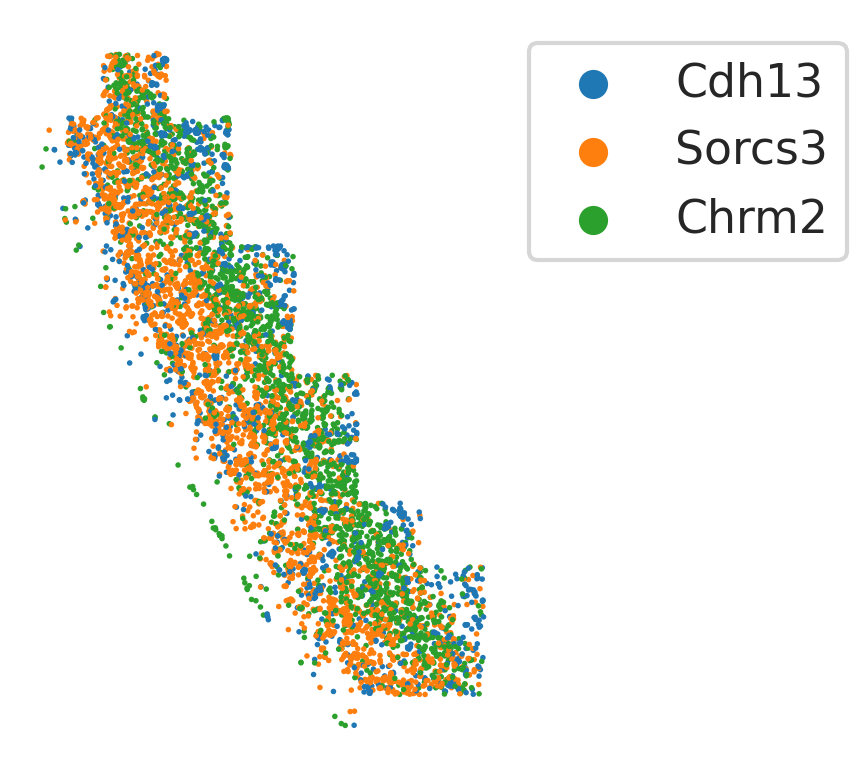

In [8]:
# check results
query_genes = ['Cdh13', 'Sorcs3', 'Chrm2']

abc = df_v1l23[df_v1l23['gene'].isin(query_genes)]  
fig, ax = plt.subplots()
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='global_x', y='global_y', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()

# rotate, calc depth and width, and viz

In [9]:
# reference line
ref_line_obj = utils_merfish.RefLineSegs(ref_line)

In [10]:
%%time
x = df_v1l23['global_x'].values
y = df_v1l23['global_y'].values
xr, yr = utils_merfish.rot2d(x, y, rotation_angle)
XY = np.vstack([xr, yr]).T 

df_v1l23['x'] = xr
df_v1l23['y'] = yr
df_v1l23['depth'] = ref_line_obj.ndist_to_qps(XY)
df_v1l23['width'] = ref_line_obj.tdist_to_qps(XY)

cond_spots = np.all([
    df_v1l23['width'] > bound_l, 
    df_v1l23['width'] < bound_r, 
    df_v1l23['depth'] < bound_d, 
], axis=0)

df_v1l23 = df_v1l23[cond_spots]

CPU times: user 13.6 s, sys: 27.1 s, total: 40.7 s
Wall time: 41.1 s


In [11]:
abc = df_v1l23[df_v1l23['gene'].isin(query_genes)]  

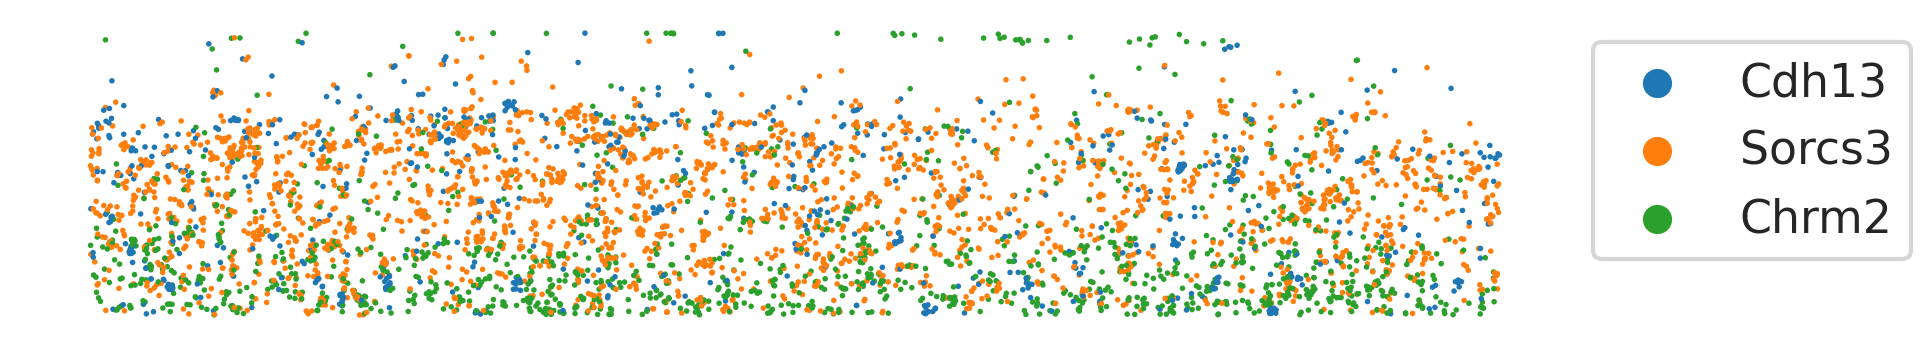

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,3))
sns.scatterplot(data=abc.sample(frac=1, replace=False), 
                x='width', y='depth', hue='gene', hue_order=query_genes, 
                s=4, edgecolor='none', ax=ax, )
ax.set_aspect('equal')
ax.axis('off')
ax.legend(bbox_to_anchor=(1,1))
ax.invert_yaxis()

# Save results

In [13]:
df_v1l23

,Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
73722141,249,0,729.16620,7335.4414,0.0,7335.4414,-729.16620,2111,Cdh4,ENSMUST00000000314,2596588902761100115,379.115292,1407.920879
73722251,208,8,735.86145,7330.3823,0.0,7330.3823,-735.86145,2111,Smo,ENSMUST00000001812,-1,387.294615,1406.044836
73722310,148,10,739.21760,7332.2993,0.0,7332.2993,-739.21760,2111,Grin2c,ENSMUST00000003351,-1,389.572324,1409.167443
73722569,354,12,737.80084,7336.4910,0.0,7336.4910,-737.80084,2111,Grm3,ENSMUST00000004076,2596588902761100115,386.564202,1412.412249
73722571,356,12,721.74695,7337.5290,0.0,7337.5290,-721.74695,2111,Grm3,ENSMUST00000004076,2596588902761100011,371.491447,1406.789360
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95231852,8,448,1287.59030,9176.6670,6.0,9176.6670,-1287.59030,2344,Jdp2,ENSMUST00000171754,-1,41.892978,3325.845554
95231853,12,449,1296.43930,9179.2580,6.0,9179.2580,-1296.43930,2344,Bmp6,ENSMUST00000171970,-1,47.989100,3332.763313
95231854,9,453,1385.89330,9170.1120,6.0,9170.1120,-1385.89330,2344,Apoe,ENSMUST00000174064,2596588903494100004,128.436929,3374.194980
95231855,63,453,1325.72600,9237.0030,6.0,9237.0030,-1325.72600,2344,Apoe,ENSMUST00000174064,-1,41.583795,3397.669286


In [14]:
df_v1l23.to_csv(fout, header=True, index=False)
!head $fout

Unnamed: 0,barcode_id,global_x,global_y,global_z,x,y,fov,gene,transcript_id,cell_id,depth,width
249,0,729.1662,7335.4414,0.0,7335.4414,-729.1661999999995,2111,Cdh4,ENSMUST00000000314,2596588902761100115,379.1152920984881,1407.9208790571192
208,8,735.86145,7330.3823,0.0,7330.3823,-735.8614499999995,2111,Smo,ENSMUST00000001812,-1,387.29461531502176,1406.044836122651
148,10,739.2176,7332.2993,0.0,7332.2993,-739.2175999999995,2111,Grin2c,ENSMUST00000003351,-1,389.5723237912969,1409.1674433537323
354,12,737.80084,7336.491,0.0,7336.491,-737.8008399999995,2111,Grm3,ENSMUST00000004076,2596588902761100115,386.5642023880123,1412.4122489581875
356,12,721.74695,7337.529,0.0,7337.529,-721.7469499999995,2111,Grm3,ENSMUST00000004076,2596588902761100011,371.4914474043988,1406.789359546501
357,12,728.83136,7337.646,0.0,7337.646,-728.8313599999996,2111,Grm3,ENSMUST00000004076,2596588902761100115,377.9075528650295,1409.7953776379577
363,12,698.85626,7340.949,0.0,7340.949,-698.8562599999996,2111,Grm3,ENSM